In [1]:
!pip install librosa numpy scikit-learn tensorflow matplotlib


In [4]:
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Step 1: Download and extract dataset automatically
dataset_url = "https://github.com/Jakobovski/free-spoken-digit-dataset/archive/refs/heads/master.zip"
dataset_zip = "master.zip"
dataset_dir = "free-spoken-digit-dataset-master/recordings/"

if not os.path.exists(dataset_dir):
    print("Downloading dataset...")
    os.system(f"wget {dataset_url} -O {dataset_zip}")
    print("Extracting dataset...")
    os.system(f"unzip -o {dataset_zip}")
else:
    print("Dataset already downloaded and extracted.")

# Step 2: Preprocess dataset
def load_audio_files(path):
    data = []
    labels = []
    for file in os.listdir(path):
        if file.endswith('.wav'):
            audio_path = os.path.join(path, file)
            audio, sr = librosa.load(audio_path, sr=16000)
            mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
            mfcc_mean = np.mean(mfcc.T, axis=0)
            data.append(mfcc_mean)
            labels.append(file[0])  # Assuming the first character of filename is the speaker label
    return np.array(data), np.array(labels)

print("Preprocessing audio files...")
X, y = load_audio_files(dataset_dir)

# Step 3: Prepare data for training
y = to_categorical(y.astype(int))  # One-hot encode labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data prepared. Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Dataset already downloaded and extracted.
Preprocessing audio files...
Data prepared. Training samples: 2400, Testing samples: 600


In [7]:
from sklearn.preprocessing import StandardScaler

# Normalize the MFCC features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Build a deeper model
model = Sequential([
    Dense(256, activation='relu', input_shape=(13,)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
print("Retraining the model...")
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64)


Retraining the model...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2724 - loss: 2.2788 - val_accuracy: 0.6850 - val_loss: 1.7674
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5865 - loss: 1.1796 - val_accuracy: 0.7050 - val_loss: 1.4637
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7193 - loss: 0.8475 - val_accuracy: 0.7267 - val_loss: 1.2278
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7687 - loss: 0.6796 - val_accuracy: 0.7533 - val_loss: 1.0182
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7942 - loss: 0.5974 - val_accuracy: 0.8167 - val_loss: 0.7977
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8277 - loss: 0.5388 - val_accuracy: 0.8383 - val_loss: 0.6459
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8337 - loss: 0.4862 - val_accuracy: 0.8783 - val_loss: 0.4939
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8545 - loss: 0.4607 - val_accuracy: 0.8833 - val_loss: 0.4144
Ep

Test Accuracy: 95.17%


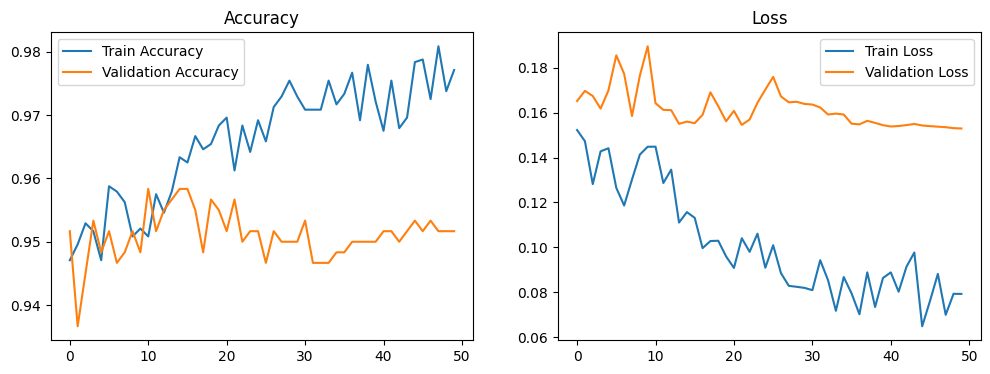

In [12]:
results = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {results[1] * 100:.2f}%")

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Add a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

print("Training with learning rate scheduler...")
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, callbacks=[lr_scheduler])


Training with learning rate scheduler...
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9495 - loss: 0.1491 - val_accuracy: 0.9517 - val_loss: 0.1652 - learning_rate: 0.0010
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9489 - loss: 0.1468 - val_accuracy: 0.9367 - val_loss: 0.1697 - learning_rate: 0.0010
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9490 - loss: 0.1184 - val_accuracy: 0.9450 - val_loss: 0.1674 - learning_rate: 0.0010
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9532 - loss: 0.1450 - val_accuracy: 0.9533 - val_loss: 0.1618 - learning_rate: 0.0010
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9512 - loss: 0.1361 - val_accuracy: 0.9483 - val_loss: 0.1700 - learning_rate: 0.0010
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9562 - loss: 0.1362 - val_accuracy: 0.9517 - val_loss: 0.1856 - learning_rate: 0.0010
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc

In [13]:
model.save("speaker_verification_model.h5")
print("Model saved as 'speaker_verification_model.h5'")


Model saved as 'speaker_verification_model.h5'


In [14]:
from tensorflow.keras.models import load_model
import librosa

# Load the saved model
model = load_model("speaker_verification_model.h5")

# Function for real-time speaker verification
def verify_speaker(audio_path):
    audio, sr = librosa.load(audio_path, sr=16000)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc.T, axis=0).reshape(1, -1)
    prediction = model.predict(mfcc_mean)
    speaker_id = np.argmax(prediction)
    confidence = np.max(prediction) * 100
    return speaker_id, confidence

# Example usage
audio_path = "free-spoken-digit-dataset-master/recordings/0_george_0.wav"  # Replace with your audio file
speaker_id, confidence = verify_speaker(audio_path)
print(f"Predicted Speaker ID: {speaker_id}, Confidence: {confidence:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Predicted Speaker ID: 4, Confidence: 96.35%
